In [51]:
# plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import folium
from folium.plugins import HeatMap

# basic
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import pylab
import category_encoders as ce

# preprocessomg
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# models
from sklearn.model_selection import ParameterGrid, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# compress warning
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [52]:
# main data
train_data_path = './dataset/train.csv'
test_data_path = './dataset/test.csv'

# auxiliary data
mrt_exist_data_path = './dataset/auxiliary-data/sg-mrt-existing-stations.csv'
mrt_planned_data_path = './dataset/auxiliary-data/sg-mrt-planned-stations.csv'
mall_data_path = './dataset/auxiliary-data/sg-shopping-malls.csv'
primary_school_data_path = './dataset/auxiliary-data/sg-primary-schools.csv'
coe_price_data_path = './dataset/auxiliary-data/sg-coe-prices.csv'
stock_price_data_path = './dataset/auxiliary-data/sg-stock-prices.csv'

# Load Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
test_data['monthly_rent'] = 0
mrt_exist_data = pd.read_csv(mrt_exist_data_path)
mrt_planned_data = pd.read_csv(mrt_planned_data_path)
mall_data = pd.read_csv(mall_data_path)
primary_school_data = pd.read_csv(primary_school_data_path)
coe_price_data = pd.read_csv(coe_price_data_path)
stock_price_data = pd.read_csv(stock_price_data_path)

# 0. EDA - Main Data


**0.1 General Info**

In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rent_approval_date   60000 non-null  object 
 1   town                 60000 non-null  object 
 2   block                60000 non-null  object 
 3   street_name          60000 non-null  object 
 4   flat_type            60000 non-null  object 
 5   flat_model           60000 non-null  object 
 6   floor_area_sqm       60000 non-null  float64
 7   furnished            60000 non-null  object 
 8   lease_commence_date  60000 non-null  int64  
 9   latitude             60000 non-null  float64
 10  longitude            60000 non-null  float64
 11  elevation            60000 non-null  float64
 12  subzone              60000 non-null  object 
 13  planning_area        60000 non-null  object 
 14  region               60000 non-null  object 
 15  monthly_rent         60000 non-null 

**0.2 Descriptive Statistics**

In [54]:
train_data.describe()

floor_area_sqm  lease_commence_date      latitude     longitude  \
count    60000.000000         60000.000000  60000.000000  60000.000000   
mean        94.480458          1990.876367      1.359443    103.840110   
std         24.082642            12.141435      0.042505      0.071627   
min         34.000000          1966.000000      1.270380    103.685228   
25%         73.000000          1981.000000      1.330939    103.778803   
50%         93.000000          1988.000000      1.354024    103.845301   
75%        110.000000          2000.000000      1.386968    103.897418   
max        215.000000          2019.000000      1.457071    103.964915   

       elevation  monthly_rent  
count    60000.0  60000.000000  
mean         0.0   2590.328333  
std          0.0    714.910468  
min          0.0    300.000000  
25%          0.0   2100.000000  
50%          0.0   2400.000000  
75%          0.0   3000.000000  
max          0.0   6950.000000

**0.3 Visualization of General Info**

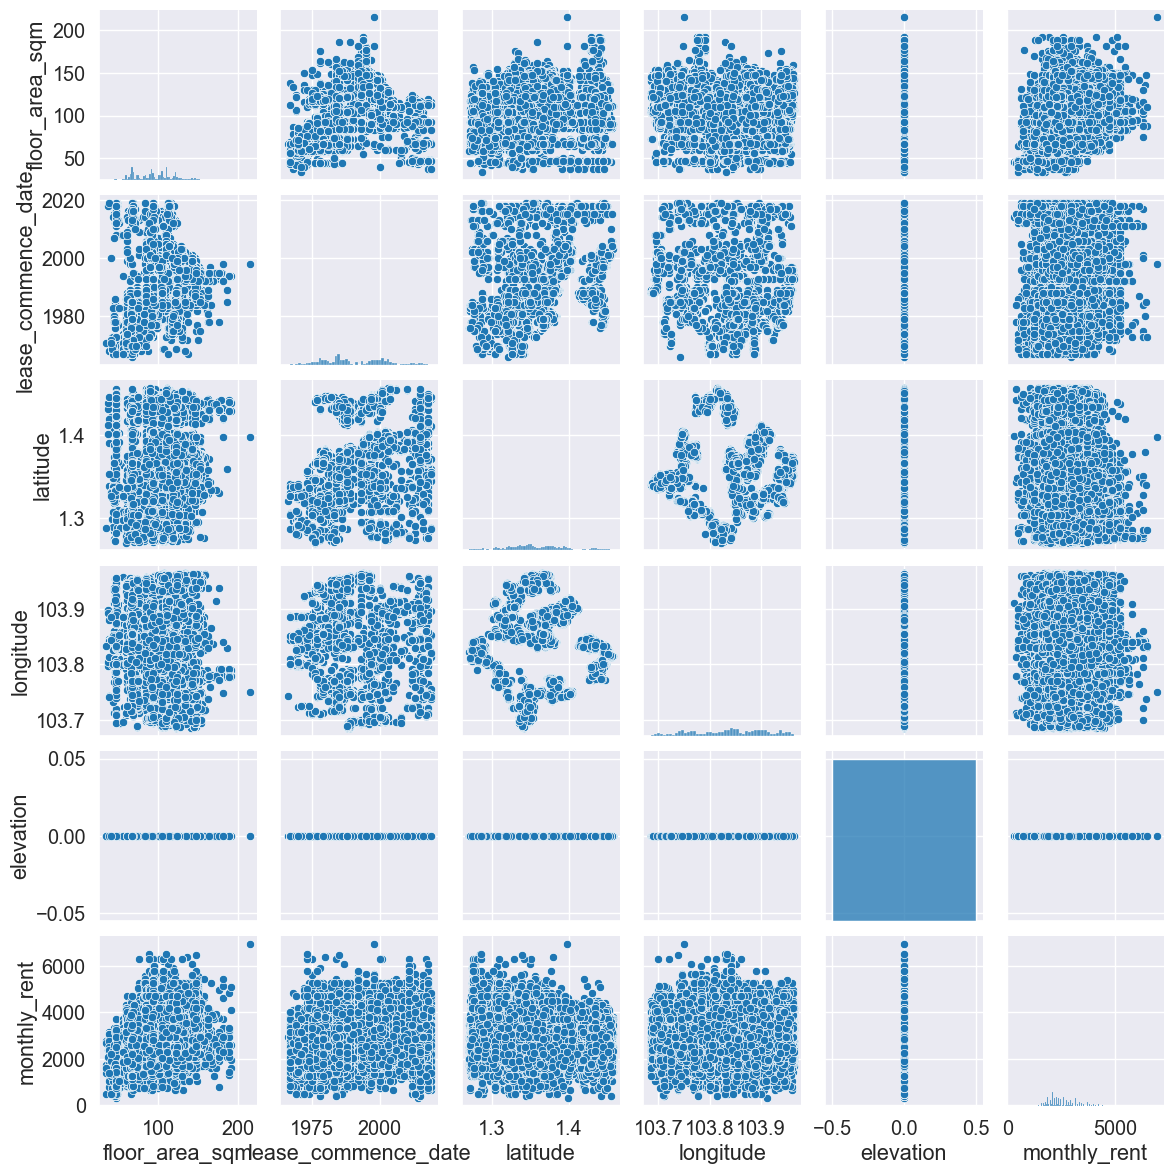

In [55]:
sns.pairplot(train_data,height=2)
plt.show()

**Observations**

There is no null value for any column in the dataset.
The scale of numerical data varies significantly, remember to normalize before analysis
There are natural groups but not clear, further observation required

**0.4 Univariate Analysis - Categorical - town & subarea**

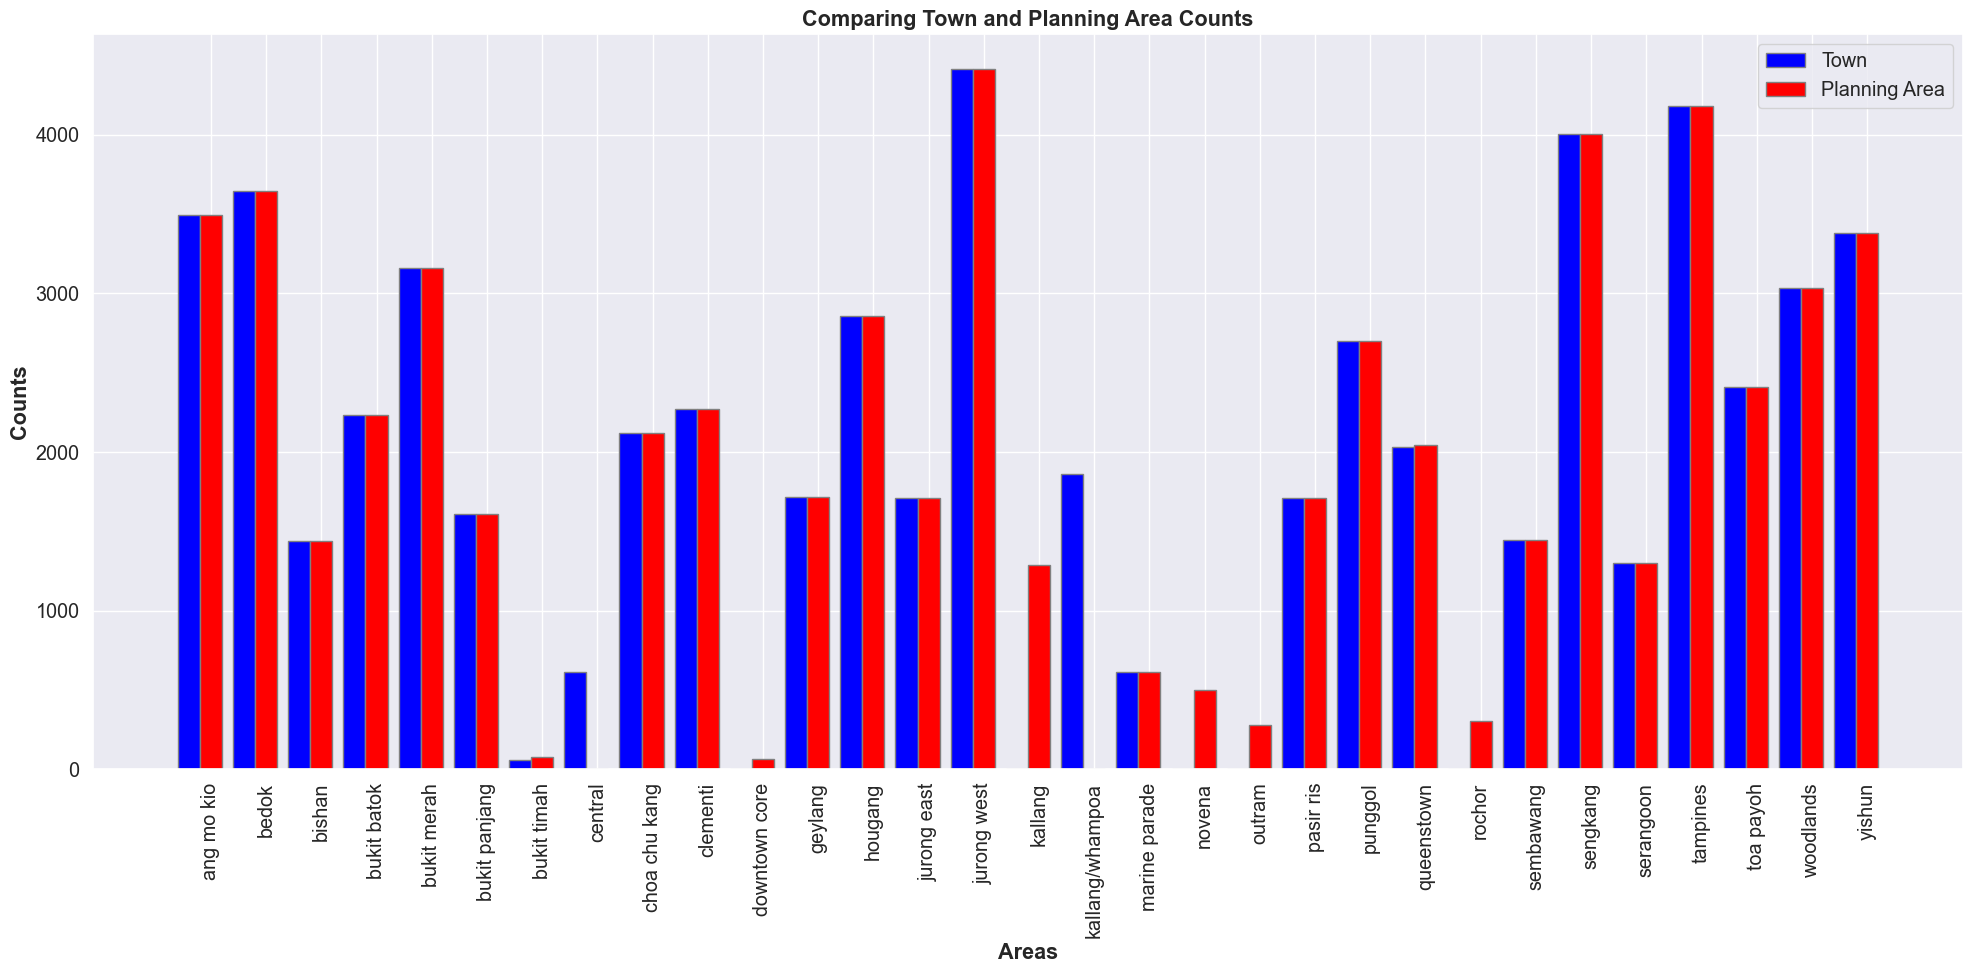

In [56]:
town_counts = train_data['town'].value_counts()
planning_area_counts = train_data['planning_area'].value_counts()



# Merge the two Series into a single DataFrame
combined_df = pd.DataFrame({'Town': town_counts, 'Planning Area': planning_area_counts}).fillna(0)

# Plotting
plt.figure(figsize=(20, 10))

# Width of a bar
width = 0.4

# Positions of bars on x axis
r1 = range(len(combined_df))
r2 = [x + width for x in r1]

# Creating bars
plt.bar(r1, combined_df['Town'], width=width, label='Town', color='blue', edgecolor='grey')
plt.bar(r2, combined_df['Planning Area'], width=width, label='Planning Area', color='red', edgecolor='grey')

# Title & Subtitle
plt.title('Comparing Town and Planning Area Counts', fontweight='bold')

# X axis
plt.xlabel('Areas', fontweight='bold')
plt.xticks([r + width for r in range(len(combined_df))], combined_df.index, rotation=90)

# Y axis
plt.ylabel('Counts', fontweight='bold')

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

**0.5 Univariate Analysis - Categorical - flat_type**

In [57]:
train_data['flat_type'].value_counts()

flat_type
4-room       12840
3-room       11125
4 room        9049
5-room        8524
3 room        7772
5 room        6235
executive     3528
2-room         617
2 room         310
Name: count, dtype: int64

**0.6 Univariate Analysis - Categorical - flat_model**

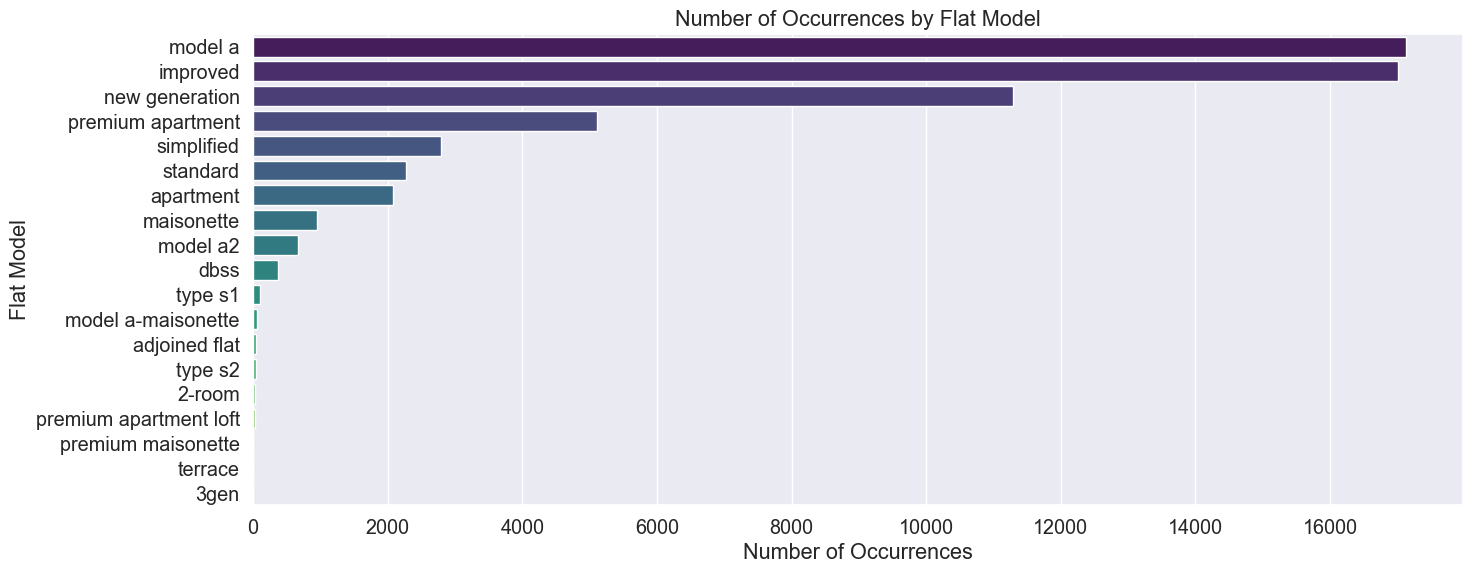

In [58]:
flat_model_counts = train_data['flat_model'].value_counts()

# Plotting
plt.figure(figsize=(15,6))  # Adjust the figure size
sns.barplot(y=flat_model_counts.index, x=flat_model_counts.values, palette='viridis')  # Use y for town names to get a horizontal bar plot

# Add titles and labels
plt.title('Number of Occurrences by Flat Model')
plt.xlabel('Number of Occurrences')
plt.ylabel('Flat Model')

# Display the plot
plt.tight_layout()
plt.show()

**0.7 Univariate Analysis - Categorical - furnished**

In [59]:
train_data['furnished'].value_counts()

furnished
yes    60000
Name: count, dtype: int64

**0.7 Univariate Analysis - Categorical - latitude & longitude**


In [60]:
latitude = train_data['latitude']
longitude = train_data['longitude']

avg_lat, avg_lon = latitude.mean(), longitude.mean()

# Create a base map
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Add the heat map
heat_data = [[lat, lon] for lat, lon in zip(train_data['latitude'], train_data['longitude'])]
HeatMap(heat_data).add_to(m)

# Display the map
m

**0.8 Univariate Analysis - Categorical - subzone**

In [61]:
train_data['subzone'].value_counts()

subzone
tampines east          2469
bedok north            1644
jurong west central    1496
woodlands east         1318
punggol field          1203
                       ... 
bencoolen                12
moulmein                 11
kampong bugis             9
frankel                   8
ulu pandan                8
Name: count, Length: 152, dtype: int64

**0.8 Univariate Analysis - Categorical - region**

In [62]:
train_data['region'].value_counts()

region
west region          14355
north-east region    14355
central region       13896
east region           9539
north region          7855
Name: count, dtype: int64

**Observation**

* town & planning_area: these two features' value overlaps, and there are 3 extra values in planning_area. binary encoded with other geographical features?
* flat_type: 4/3/5 rooms are most popular, does that mean sufficient demand or supply? (may influence price)
* furnished - 100% furnished, can we drop this feature?
* latitude & longitude - there are actually naturally formed groups, how to group them properly?
* subzone - maybe can be used with the latitude * longitude?
* region - 5 disctince values, correspond to the heat map

**0.8 Univariate Analysis - Numerical - monthly_rent**

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


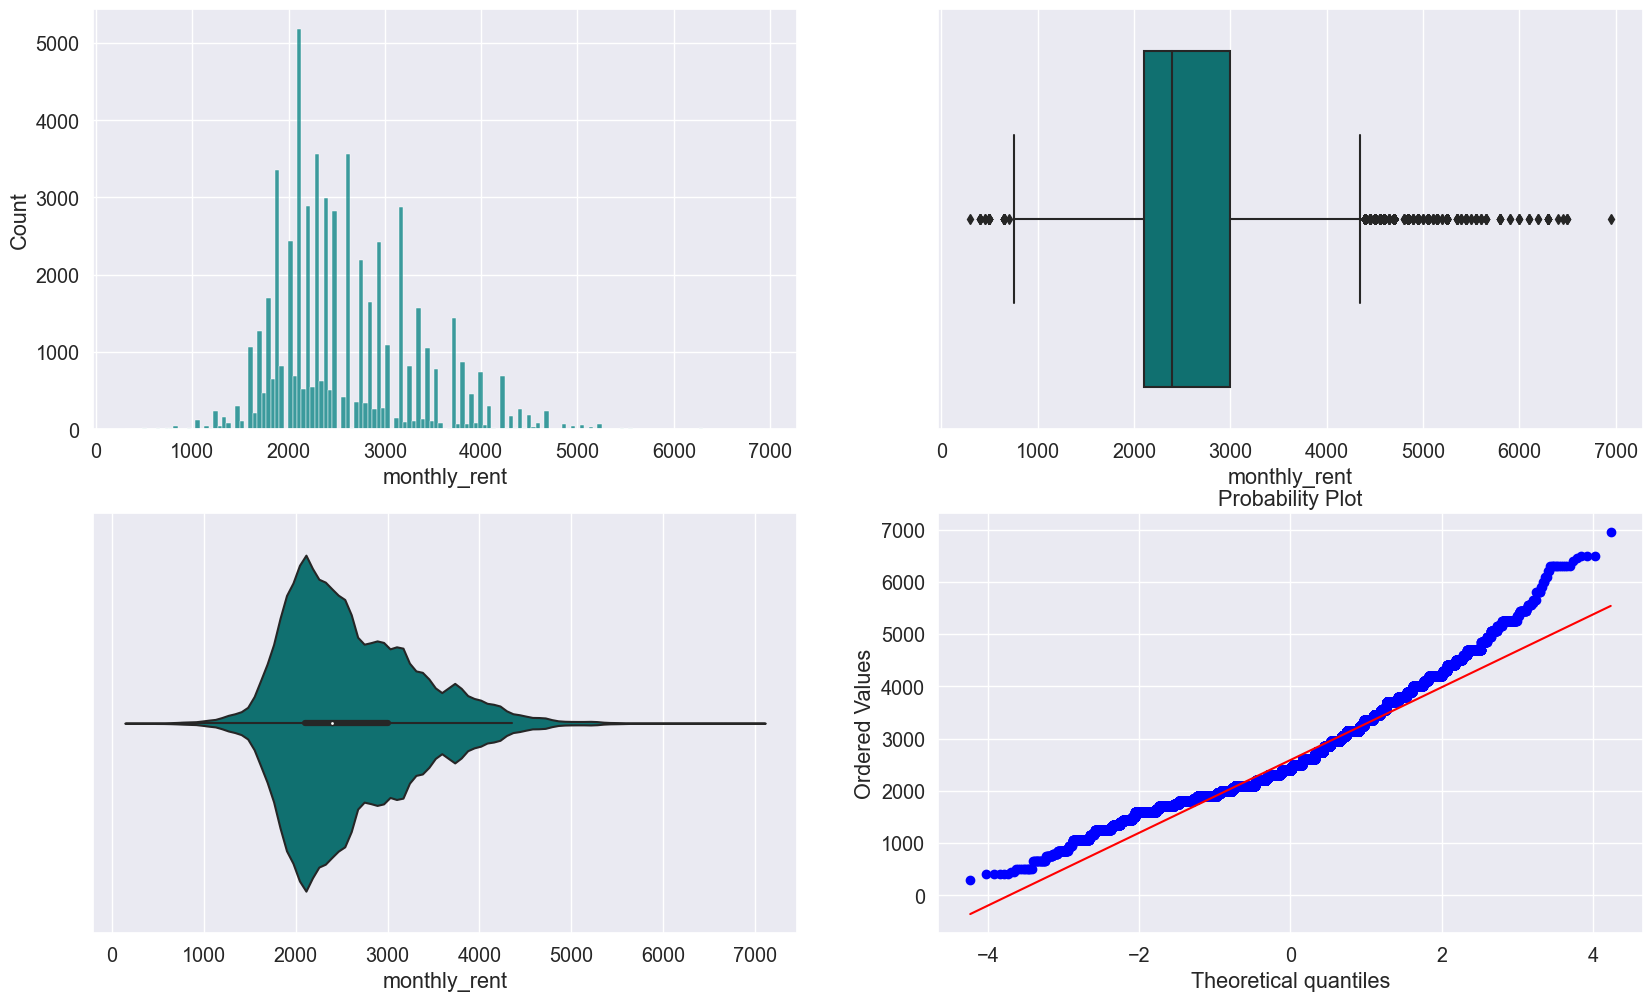

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = train_data['monthly_rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = train_data['monthly_rent'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = train_data['monthly_rent'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(train_data['monthly_rent'], plot=pylab)
pylab.show()

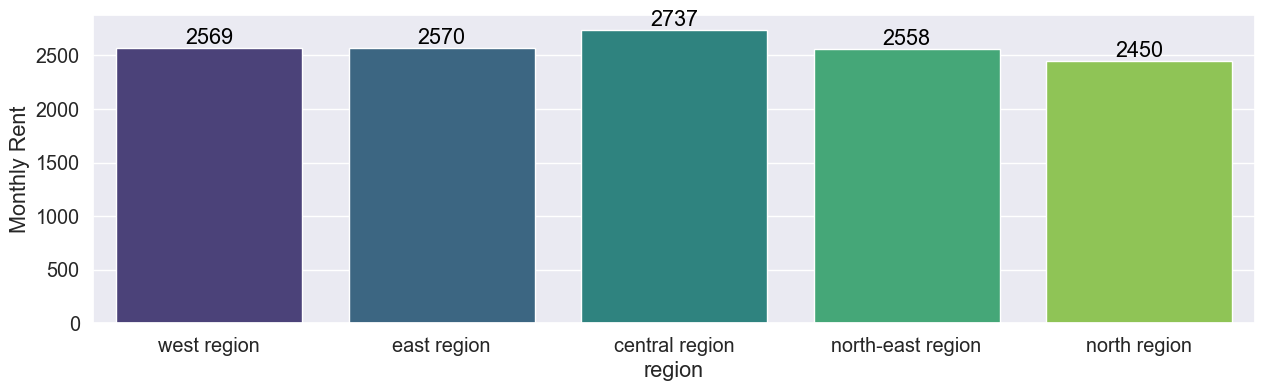

In [64]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['region'],
                 y=train_data['monthly_rent'],
                 palette='viridis',
                 ci = None)
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

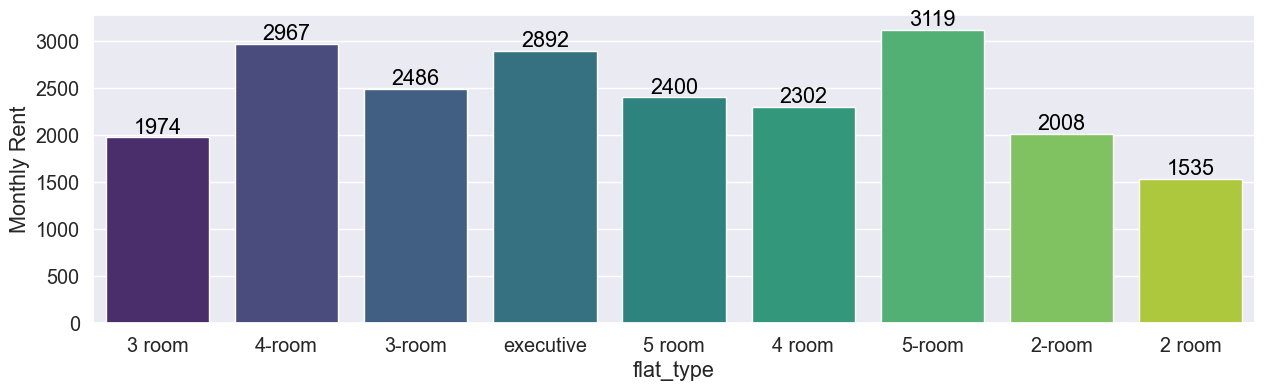

In [65]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['flat_type'],
                 y=train_data['monthly_rent'],
                 palette='viridis',
                 ci = None)
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

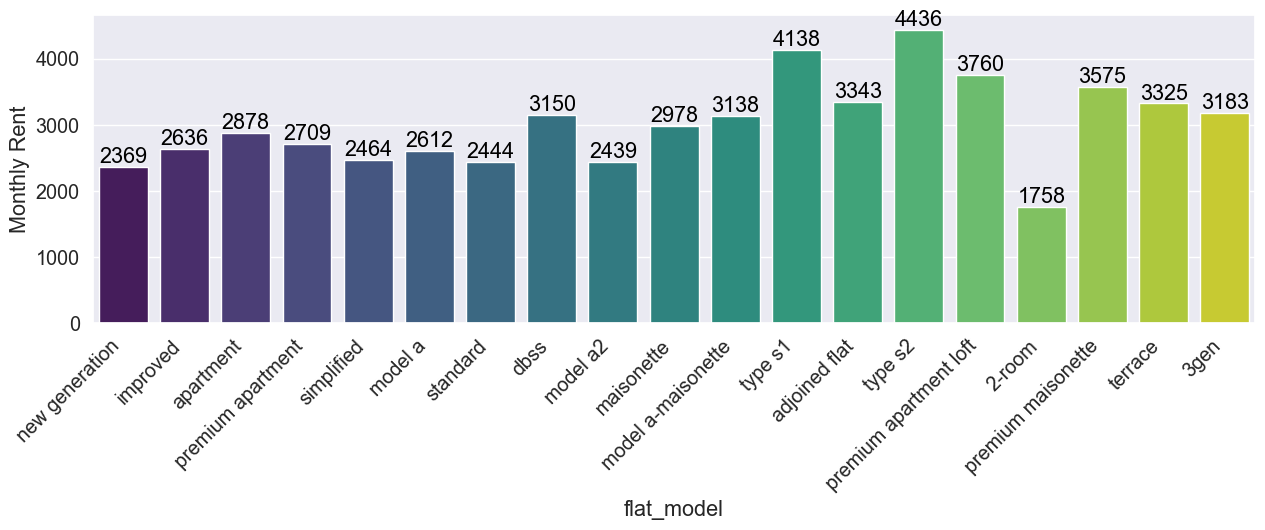

In [66]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['flat_model'],
                 y=train_data['monthly_rent'],
                 palette='viridis',
                 ci = None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

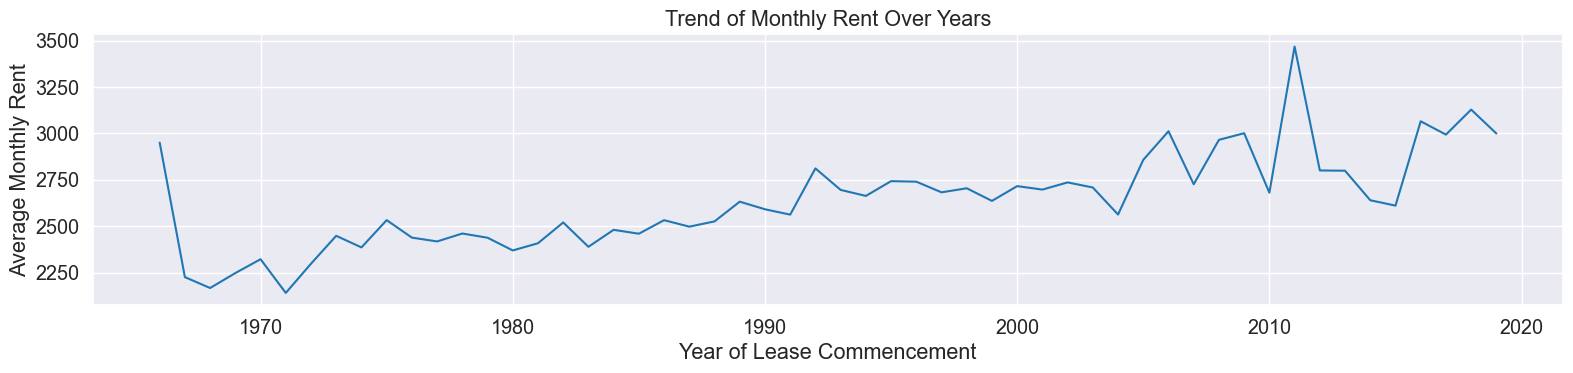

In [67]:
train_data = train_data.sort_values('lease_commence_date')

# Plot
plt.figure(figsize=(16, 4))
sns.lineplot(x='lease_commence_date', y='monthly_rent', data=train_data, ci=None)

plt.title('Trend of Monthly Rent Over Years')
plt.xlabel('Year of Lease Commencement')
plt.ylabel('Average Monthly Rent')
plt.tight_layout()
plt.show()

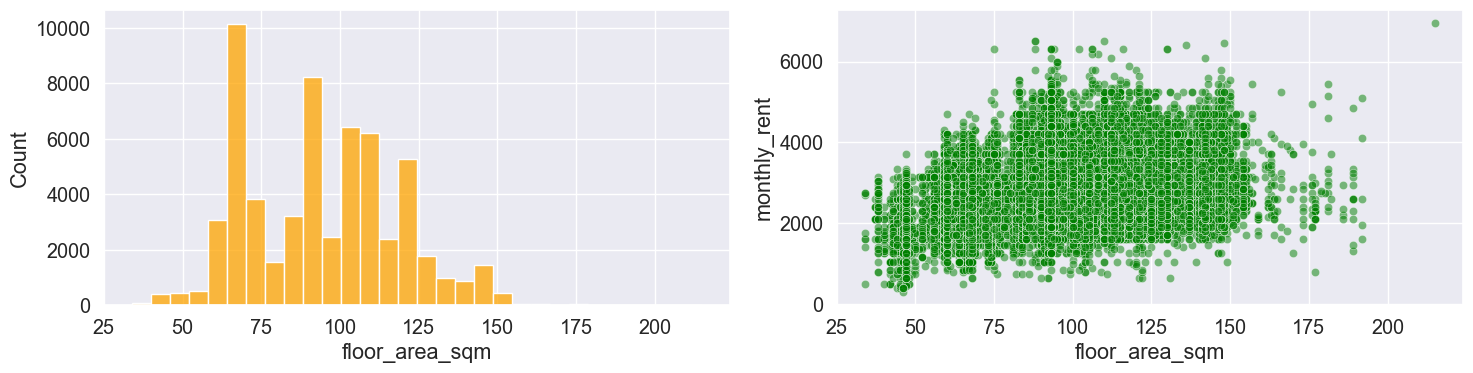

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(train_data['floor_area_sqm'], bins=30, kde=False, color='orange', ax=ax[0])  # Adjust position as desired
sns.scatterplot(x=train_data['floor_area_sqm'], y=train_data['monthly_rent'], ax=ax[1], color='green', alpha=0.5)  # Adjust position as desired

plt.tight_layout()
plt.show()

**Observation**
1. monthly rent
* it's not heavily skewed, but there are definately outliers
* regions - the average rent across different regions are roughly the same
* flat_type - the average rent is positively correlated to the #room
* flat_model - those with extremely low frequency in flat_model usually have a high price
* lease_commence_date - graph indicates the rent is increasing yearly, and exhibit up and downs in each decade. this can be combined with the auxiliary data to analyze the influence of economics
* floor_area_sqm - generally normal distribution, but obvious outliers
* latitude&longitude - observe from a higher angle, there are definately groups

# 1. Preprocessing

## 1.1 Cleaning

In [69]:
train_data['flat_type'] = train_data['flat_type'].str.replace("-", " ")
test_data['flat_type'] = test_data['flat_type'].str.replace("-", " ")

train_data.head()
# test_data.head()

rent_approval_date         town block         street_name flat_type  \
48836            2023-01  jurong east    38  teban gardens road    3 room   
12177            2022-07   queenstown    82  commonwealth close    3 room   
18295            2021-07      geylang    64        Circuit Road    3 room   
30958            2021-07    toa payoh   112  Lorong 1 Toa Payoh    3 room   
11420            2021-02   queenstown    82  commonwealth close    2 room   

      flat_model  floor_area_sqm furnished  lease_commence_date  latitude  \
48836   improved            67.0       yes                 1966  1.321073   
12177   standard            60.0       yes                 1967  1.304221   
18295   standard            59.0       yes                 1967  1.326984   
30958   improved            65.0       yes                 1967  1.341553   
11420   standard            46.0       yes                 1967  1.304221   

        longitude  elevation         subzone planning_area          region  \
48836  103.743007        0.0   teban gardens   jurong east     west region   
12177  103.800400        0.0    commonwealth    queenstown  central region   
18295  103.887148        0.0      macpherson       geylang  central region   
30958  103.845490        0.0  toa payoh west     toa payoh  central region   
11420  103.800400        0.0    commonwealth    queenstown  central region   

       monthly_rent  
48836          2950  
12177          2250  
18295          2100  
30958          2100  
11420          1450

## 1.2 Encoding

In [70]:
# Encoding Functions
def encode_one_hot(data: pd.DataFrame, column_name: str, encoder: ce.OneHotEncoder):
    return encoder.transform(data)

def encode_binary(data: pd.DataFrame, column_name: str, encoder: ce.BinaryEncoder):
    return encoder.transform(data)

def encode_normalization_with_scaler(data: pd.DataFrame, column_name: str, scaler, keep_origin=False):
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(data[[column_name]])

    new_column_name = column_name
    if keep_origin:
        new_column_name = column_name + '_norm'

    data[new_column_name] = scaler.transform(data[[column_name]])
    return data, scaler

def encode_dict_map(data: pd.DataFrame, column_name: str, transform_map: dict):
    data[column_name] = data[column_name].map(transform_map)
    return data

def encode_function_map(data: pd.DataFrame, column_name: str, transform_func):
    data[column_name] = data[column_name].apply(transform_func)
    return data

def encode_drop(data: pd.DataFrame, column_name: str):
    data.drop(columns=[column_name], inplace=True)
    return data

# 1. rent_approval_date:
# a. function mapping: "year*10+month". b.drop the attribute: this attribute may be replaced by "lease commence date" or the stock amount
def transform_func_date(value):
    splits = value.split('-')
    return int(splits[0]) * 100 + int(splits[1])

train_data = encode_function_map(train_data, 'rent_approval_date', transform_func_date)
test_data = encode_function_map(test_data, 'rent_approval_date', transform_func_date)

# 2. town
# a. binary encoding: 26 unique values.
town_encoder = ce.BinaryEncoder(cols=['town']).fit(train_data)
train_data = encode_binary(train_data, 'town', town_encoder)
test_data = encode_binary(test_data, 'town', town_encoder)

# 3. block
# a. binary encoding. b. way is drop attribute, similar to "town"
block_encoder = ce.BinaryEncoder(cols=['block']).fit(train_data)
train_data = encode_binary(train_data, 'block', block_encoder)
test_data = encode_binary(test_data, 'block', block_encoder)

# 4. street name - Similar to attribute "block"
street_name_encoder = ce.BinaryEncoder(cols=['street_name']).fit(train_data)
train_data = encode_binary(train_data, 'street_name', street_name_encoder)
test_data = encode_binary(test_data, 'street_name', street_name_encoder)

# 5. flat type
# a.one-hot encoding: only 5 unique values b. binary encoding c.dict mapping to map the type into number in order
flat_type_mapping_dict = {'2 room': 2, '3 room': 3, '4 room': 4, '5 room': 5, 'executive': 6}
train_data = encode_dict_map(train_data, 'flat_type', flat_type_mapping_dict)
test_data = encode_dict_map(test_data, 'flat_type', flat_type_mapping_dict)

# 6. flat model
# a. binary encoding. b.word embedding.
flat_model_encoder = ce.BinaryEncoder(cols=['flat_model']).fit(train_data)
train_data = encode_binary(train_data, 'flat_model', flat_model_encoder)
test_data = encode_binary(test_data, 'flat_model', flat_model_encoder)

# 7. floor area sqm
# use it directly or use it after normalization.
scaler = MinMaxScaler().fit(train_data[['floor_area_sqm']])
train_data, scaler = encode_normalization_with_scaler(train_data, 'floor_area_sqm', scaler)
test_data, _ = encode_normalization_with_scaler(test_data, 'floor_area_sqm', scaler)

# 8. furnished
# drop attributes: the value of this attribute for all data is "yes"
train_data = encode_drop(train_data, 'furnished')
test_data = encode_drop(test_data, 'furnished')

# 9. lease commence date: Similar to attribute "rent_approval_date"
# train_data = encode_function_map(train_data, 'lease_commence_date', transform_func_date)
# test_data = encode_function_map(test_data, 'lease_commence_date', transform_func_date)

# 10. latitude & longitude
# train_data, scaler = encode_normalization_with_scaler(train_data, 'latitude', MinMaxScaler())
# test_data, _ = encode_normalization_with_scaler(test_data, 'latitude', scaler)
# train_data, scaler = encode_normalization_with_scaler(train_data, 'longitude', MinMaxScaler())
# test_data, _ = encode_normalization_with_scaler(test_data, 'longitude', scaler)

# 11. elevation - Similar to attribute "furnished"
train_data = encode_drop(train_data, 'elevation')
test_data = encode_drop(test_data, 'elevation')

# 12. subzone
# a. binary encoding b. drop attribute: this attribute may be replaced by "town-block-street_name" or "latitude-longitude"
subzone_encoder = ce.BinaryEncoder(cols=['subzone']).fit(train_data)
train_data = encode_binary(train_data, 'subzone', subzone_encoder)
test_data = encode_binary(test_data, 'subzone', subzone_encoder)

# 13. planning area - similar to attribute "subzone"
planning_area_encoder = ce.BinaryEncoder(cols=['planning_area']).fit(train_data)
train_data = encode_binary(train_data, 'planning_area', planning_area_encoder)
test_data = encode_binary(test_data, 'planning_area', planning_area_encoder)

# 14.region
# a. one-hot encoding: only 5 categories in this attribute b. binary encoding
region_encoder = ce.BinaryEncoder(cols=['region']).fit(train_data)
train_data = encode_binary(train_data, 'region', region_encoder)
test_data = encode_binary(test_data, 'region', region_encoder)

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
48836              202301       0       0       0       0       1        0   
12177              202207       0       0       0       1       0        0   
18295              202107       0       0       0       1       1        0   
30958              202107       0       0       1       0       0        0   
11420              202102       0       0       0       1       0        0   

       block_1  block_2  block_3  ...  subzone_7  planning_area_0  \
48836        0        0        0  ...          1                0   
12177        0        0        0  ...          0                0   
18295        0        0        0  ...          1                0   
30958        0        0        0  ...          0                0   
11420        0        0        0  ...          0                0   

       planning_area_1  planning_area_2  planning_area_3  planning_area_4  \
48836                0                0                0                1   
12177                0                0                1                0   
18295                0                0                1                1   
30958                0                1                0                0   
11420                0                0                1                0   

       region_0  region_1  region_2  monthly_rent  
48836         0         0         1          2950  
12177         0         1         0          2250  
18295         0         1         0          2100  
30958         0         1         0          2100  
11420         0         1         0          1450  

[5 rows x 56 columns]

# 2. Feature Engineering
1. Binning of numerical variables - https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/discussion/32116
2. create new features by encoding categorical variables using statistics (like mean, median, standard deviation, etc.) of continuous variables. https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/discussion/32123

# 4. Methods - Regression Models

After EDA and data preprocessing, we can now apply data mining methods for prediction. In this section, we choose different algorithms to generate regression models, including Multiple Linear Regression, Random Forest, XGBoost and LightGBM. The general proposal is to split the preprocessed dataset into train/test data, train and validate with train data, and evaluate the optimized model performance with test data. Finally, compare the models to get a overall picture of how well these regression models perform.

Different modelling methods may involve different data processing and feature engineering techniques. Therefore, instead of using the train_data/test_data directly, we create separate copies of the dataset for each method to generate the corresponding training/testing data for that particular method.

## 4.1 Multiple Linear Regression

In [71]:
# train_data_mlr = train_data.copy()

In [72]:
# X_train = train_data_mlr.drop(['monthly_rent'], axis = 1)
# y_train = train_data_mlr['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

### Model Training

In [73]:
# from sklearn.linear_model import LinearRegression

In [74]:
# # Instantiate a Linear Regression model, for simplicity here we first take all attributes into consideration
# mlr = LinearRegression()
# mlr.fit(X_train, y_train)

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [75]:
# y_pred_train = mlr.predict(X_train)

In [76]:
# # Model evaluation metrics
# print('R^2:',metrics.r2_score(y_train, y_pred_train))
# print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
# print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
# print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
# print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

In [77]:
# # Visualizing
# plt.scatter(y_train, y_pred_train)
# plt.xlabel("Actual Price")
# plt.ylabel("Predicted Price")
# plt.title("Actual vs Predicted")
# plt.show()

**Assumptions on MLR Models**

There are some main assumptions on Multiple Regression Models, which are listed below:

* Linearity
* No Multi-Collinearity
* Homoskedasticity
* Independence of independent variable
* Normality
* Independence of errors

We should conduct examinations on whether the assumptions above are satisfied in this context. Basic methods include using diagnostic plots for the relevant analysis. For example, we can use residual plots to check if homoskedasticity is violated or the errors' independency. Also, scatter plots of dependent versus independent variables can help us find non-linear relationships and so on.

* **Linearity**

Linearity in MLR means that the relationship between the independent variables (features) and the dependent variable (target) is linear.

In [78]:
# X_train.columns

In [79]:
# numerical_attributes = ['floor_area_sqm', 'latitude', 'longitude']
# X_plot = X_train.loc[:,numerical_attributes]
# fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

# axs = axs.flatten()
# for i, k in enumerate(numerical_attributes):
#     sns.regplot(y=y_train, x=X_plot[k], ax=axs[i], scatter_kws={"color": "teal"}, line_kws={"color": "red"})
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

* **No Multi-Collinearity**

Multicollinearity occurs when two or more independent variables in the MLR model are highly correlated, making it difficult to separate their individual effects on the dependent variable. It can impact the reliability of your regression model's coefficients and predictions. 

We use the Correlation Matrix to have a look at the multi-collinearity across all variables first. Look for high correlation coefficients (typically greater than 0.7) between pairs of variables. High correlations suggest multicollinearity.

In [80]:
# # Display Correlation Matrix
# corrMatrix = X_train.corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.show()

`flat_type` and `floor_area_sqm` has a correlation coefficient of 0.95, and `town` and `planning_area` has a correlation coefficient of 0.97. This may suggest multicollinearity.

Note that `flat_type`, `town` and `planning_area` are  encoded and is not numeric values by nature, so we may consider other encoding methods for avoiding multi-collinearity across the variables.

Then we use another metrics Variance Inflation Factor (VIF) to measure how much the variance of the estimated regression coefficients is increased due to multi-collinearity. Calculate the VIF for each independent variable. High VIF values (typically greater than 10) indicate multicollinearity.

In [81]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [82]:
# def calc_vif(X):
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     return(vif)

In [83]:
# calc_vif(X_train)
## DOES NOT WORK 
## Ensure that the input data you're using with the isfinite function is of a numeric data type (e.g., float, int) because isfinite is typically used to check the finiteness of numeric values. If your data contains non-numeric or incompatible data types, you'll encounter this error.

* **Homoskedasticity**

Homoscedasticity means that the variance of the residuals (the differences between the observed values and the predicted values) is constant across all levels of the independent variables. If homoscedasticity is violated, it can lead to problems such as biased coefficient estimates and incorrect inference.

In [84]:
# plt.scatter(y_pred_train, y_train - y_pred_train)
# plt.title("Residual vs Fit Plot")
# plt.xlabel("Predicted")
# plt.ylabel("Residuals")
# plt.show()

We can observe that there is a random scattering of points with no discernible pattern. As in a homoskedastic dataset, the points should be evenly scattered around the horizontal line at 0 (the residuals have constant variance), we can come to the conclusion that the Homoskedasticity is not violated.

Also, we do not observe a funnel-shaped, fan-shaped pattern, or any other systematic change in the spread of residuals as the fitted values change, which suggests heteroskedasticity (the variance of residuals is not constant).

* **Independence of independent variables**

MLR assumes that independent variables are not perfectly correlated with each other (i.e., they are independent). Violations of this assumption can lead to unstable coefficient estimates and difficulties in interpreting their individual effects.

In [85]:
# # Independence of X variables-'floor_area_sqm'
# plt.scatter(X_train['floor_area_sqm'], y_train - y_pred_train)
# plt.title("Floor Area Size vs Residuals")
# plt.xlabel("floor_area_sqm")
# plt.ylabel("Residuals")
# plt.show()

In [86]:
# # Independence of X variables-'latitude'
# plt.scatter(X_train['latitude'], y_train - y_pred_train)
# plt.title("Latitude vs Residuals")
# plt.xlabel("latitude")
# plt.ylabel("Residuals")
# plt.show()

In [87]:
# # Independence of X variables-'longitude'
# plt.scatter(X_train['longitude'], y_train - y_pred_train)
# plt.title("Longitude vs Residuals")
# plt.xlabel("latitude")
# plt.ylabel("Residuals")
# plt.show()

The plots above all show that residuals do appear randomly and symmetrically distributed around zero under all conditions, which prove the independence.

* **Normality**

MLR assumes that the residuals (the differences between the observed and predicted values) are normally distributed. Deviations from normality can impact the validity of statistical inference, such as hypothesis tests and confidence intervals.

In [88]:
# # Normality of residuals
# sns.distplot(y_train - y_pred_train)
# plt.title("Normality of Residuals")
# plt.xlabel("Residuals")
# plt.ylabel("Frequency")
# plt.show()

We can see fro the plot above that the residuals are normally distributed, which means the normality assumption is satiefied.

* **Independence of errors**

Independence of errors states that the residuals (the differences between the observed values and the predicted values) should be independent of each other. Violations of this assumption can lead to incorrect parameter estimates, unreliable hypothesis tests, and inaccurate predictions. 

Here we use *Durbin-Watson Test* for checking independence of errors. This statistical test checks for the presence of autocorrelation in the residuals. A Durbin-Watson statistic value close to 2 indicates no autocorrelation.

In [89]:
# durbin_watson_statistic = sm.stats.stattools.durbin_watson(y_train - y_pred_train)
# print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')

The Durbin-Watson statistic value is close to 2, which means there is no autocorrelation (i.e. the assmuption is satisfied).

#### Evaluate the model on test dataset

After the evalution on the training dataset, as well as the checks for MLR assmuptions and corresponding model refinement, we can use the model as the final  MLR model and evaluate its performance on the test dataset.

In [90]:
# y_pred_test = mlr.predict(X_test)

In [91]:
# mlr_dict = {'Model':'Multiple Linear Regression',
#           'R^2':metrics.r2_score(y_test, y_pred_test),
#           'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
#           'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
#           'MSE':metrics.mean_squared_error(y_test, y_pred_test),
#           'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

# mlr_metrics = pd.DataFrame.from_dict(mlr_dict, orient = 'index').T

# # Display model performance metrics
# mlr_metrics

### Analysis

> TODO

</br>

## 4.2 Random Forest Regressor

In [92]:
# train_data_rf = train_data.copy()
# # test_data_rf = test_data.copy()

In [93]:
# X_train = train_data_rf.drop(['monthly_rent'], axis = 1)
# y_train = train_data_rf['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

### Model Training

In [94]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

We use GridSearchCV as a technique to systematically search through different combinations of hyperparameters to find the best set of hyperparameters for RF model.

In [95]:
# rf_param_grid = {
#     'max_depth': [90, 100], # Maximum number of levels in each decision tree
# #     'max_depth': [80, 90, 100],
#     'max_features': [2, 3], # Maximum number of features considered for splitting a node
#     'min_samples_leaf': [1, 3], # Minimum number of data points allowed in a leaf node
# #     'min_samples_leaf': [1, 3, 4, 5],
#     'n_estimators': [300, 600] # Number of trees in the forest
# #     'n_estimators': [100, 300, 600]
# }

In [96]:
# rf_reg = RandomForestRegressor(random_state = 42)
# rf_grid = GridSearchCV(estimator = rf_reg, param_grid = rf_param_grid, cv=5, n_jobs=-1, verbose=2)

In [97]:
# rf_grid.fit(X_train, y_train)

In [98]:
# rf_grid.best_params_

In [99]:
# # Get best RF estimator based on best parameters gemerated from above
# rf = rf_grid.best_estimator_

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [100]:
# # Use RF regressor to predict on training set
# y_pred_train = rf.predict(X_train)

In [101]:
# # Model evaluation metrics
# print('R^2:',metrics.r2_score(y_train, y_pred_train))
# print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
# print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
# print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
# print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

#### Evaluate the model on testing dataset

In [102]:
# y_pred_test = rf.predict(X_test)

In [103]:
# rf_dict = {'Model':'Random Forest Regressor',
#           'R^2':metrics.r2_score(y_test, y_pred_test),
#           'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
#           'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
#           'MSE':metrics.mean_squared_error(y_test, y_pred_test),
#           'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

# rf_metrics = pd.DataFrame.from_dict(rf_dict, orient = 'index').T

# # Display model performance metrics
# rf_metrics

### Analysis

* **Importance of the features**

In [104]:
# rf.feature_importances_

In [105]:
# rf_features = pd.DataFrame([X_train.columns, rf.feature_importances_]).T
# rf_features = rf_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
# rf_features.sort_values(by = 'Importance Score', ascending = False)

</br>

## 4.3 XGBoost Regressor

In [106]:
# train_data_rf = train_data.copy()
# # test_data_rf = test_data.copy()

In [107]:
# X_train = train_data_rf.drop(['monthly_rent'], axis = 1)
# y_train = train_data_rf['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

### Model Training

In [108]:
# import xgboost as xgb
# from xgboost import plot_importance

In [109]:
# xgb_param_grid = {"learning_rate": [0.05, 0.1, 0.2], # Step size shrinkage used in update to prevents overfitting.
#                   "max_depth"        : [6, 8, 9, 10], # Maximum depth of a tree. 
#                   "min_child_weight" : [1, 3, 5, 7], # Minimum number of instances required in a child node
#                   "gamma"            : [0.0, 0.1, 0.2, 0.3], # Minimum loss reduction required to make a further partition on a leaf node of the tree.
#                   "colsample_bytree" : [0.3, 0.4, 0.6, 0.8] # Number of features supplied to a tree
# }

In [110]:
# xgb_reg = xgb.XGBRegressor(seed = 42, objective ='reg:squarederror')
# xgb_grid = GridSearchCV(estimator = xgb_reg, param_grid = xgb_param_grid, cv=5, n_jobs=-1, verbose=2)

**TO BE CHECKED!!! Failed**

In [111]:
# xgb_grid.fit(X_train, y_train)

In [112]:
# xgb_grid.best_params_

In [113]:
# Get best XGBoost estimator based on best parameters gemerated from above
# xgb = xgb_grid.best_estimator_

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [114]:
# # Use XGBoost regressor to predict on training set
# y_pred_train = xgb.predict(X_train)

In [115]:
# # Model evaluation metrics
# print('R^2:',metrics.r2_score(y_train, y_pred_train))
# print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
# print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
# print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
# print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

#### Evaluate the model on testing dataset

In [116]:
# y_pred_test = xgb.predict(X_test)

In [117]:
# xgb_dict = {'Model':'XGBoost Regressor',
#           'R^2':metrics.r2_score(y_test, y_pred_test),
#           'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
#           'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
#           'MSE':metrics.mean_squared_error(y_test, y_pred_test),
#           'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

# xgb_metrics = pd.DataFrame.from_dict(xgb_dict, orient = 'index').T

# # Display model performance metrics
# xgb_metrics

### Analysis

* **Importance of the features**

In [118]:
# xgb_features = pd.DataFrame([X_train.columns, xgb.feature_importances_]).T
# xgb_features = xgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
# xgb_features.sort_values(by = 'Importance Score', ascending = False).head(15)

In [119]:
# plot_importance(xgb, max_num_features = 10)

</br>

## 4.4 LightGBM Regressor

In [120]:
# train_data_rf = train_data.copy()
# # test_data_rf = test_data.copy()

In [121]:
# X_train = train_data_rf.drop(['monthly_rent'], axis = 1)
# y_train = train_data_rf['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

#### Model Training

In [122]:
# import lightgbm as lgb

In [123]:
# gbm_param_grid = {'metric': ['rmse'],
#                   'max_depth': [9,10,11,12,13], 
#                   'bagging_fraction': [0.8, 0.9, 1],
#                   'feature_fraction': [0.8, 0.9, 1],
#                   'min_data_in_leaf': [20,50,80],
#                   'learning_rate': [0.01,0.05,0.1,0.2]}

In [124]:
# lgb_reg = lgb.LGBMRegressor(seed = 42, num_iterations = 1200)

# lgb_grid = GridSearchCV(estimator = lgb_reg, param_grid = gbm_param_grid, cv=5, n_jobs=-1, verbose=1)

**TO BE CHECKED**

In [125]:
#lgb_grid.fit(X_train, y_train)

## 5. Model Comparison

In [126]:
# df_metrics = pd.concat([mlr_metrics, rf_metrics, xgb_metrics, lgbm_metrics])
# df_metrics.sort_values(by = 'RMSE', ascending = True)

See from the metrics comparison above, XXXXXXX achieves the best performance on the test set with an RMSE of XXXXXXX. 

# 5. Ensemble Models

5.1 Baseline

In [127]:
# *******************Linear model*******************
def get_model():
    net = nn.Sequential(nn.Linear(in_features, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1),)
    return net

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam optimization
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_model()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_model()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
    test_data['Predicted'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([df_id['Id'], test_data['Predicted']], axis=1)
    return submission, train_ls

In [128]:
# train_data.reset_index(drop=True, inplace=True)
# train_data.head()

In [129]:
train_len = train_data.shape[0] * 0.8
numeric_attributes=['flat_type', 'floor_area_sqm', 'latitude', 'longitude']
train_data_linear = train_data.loc[:train_len-1,numeric_attributes]
train_data_rent = train_data.loc[:train_len-1,['monthly_rent']]
train_data_rent.shape

(2713, 1)

In [130]:
test_data_linear = train_data.loc[train_len:,numeric_attributes]
test_data_linear.head()
print(train_data_linear.shape, test_data_linear.shape)

(2713, 4) (4044, 4)


In [131]:
train_attributes = torch.tensor(train_data_linear.values, dtype=torch.float32)
test_attributes = torch.tensor(test_data_linear.values, dtype=torch.float32)
train_labels_linear = torch.tensor(train_data_rent.values.reshape(-1, 1), dtype=torch.float32)
loss = nn.MSELoss()
in_features = train_attributes.shape[1]

fold 1, train log rmse 0.243056, valid log rmse 0.255522
fold 2, train log rmse 0.237443, valid log rmse 0.265488
fold 3, train log rmse 0.245234, valid log rmse 0.233983
fold 4, train log rmse 0.249114, valid log rmse 0.244357
fold 5, train log rmse 0.246490, valid log rmse 0.230520
5-fold cross-validation: average train log rmse: 0.244267, average test log rmse: 0.245974


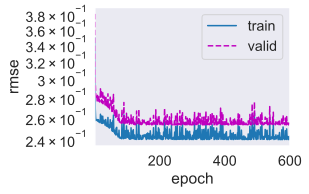

In [132]:
# train linear model
k, num_epochs, lr, weight_decay, batch_size = 5, 600, 0.01, 0, 64 # adjust hyperparameter
train_l, valid_l = k_fold(k, train_attributes, train_labels_linear, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold cross-validation: average train log rmse: {float(train_l):f}, '
      f'average test log rmse: {float(valid_l):f}')

train log rmse 0.243241


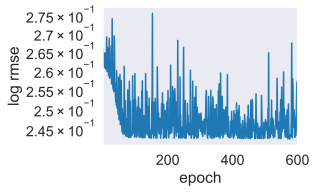

In [133]:
# predict linear model
submission, train_ls = train_and_pred(train_attributes, test_attributes, train_labels_linear, test_data,
               num_epochs, lr, weight_decay, batch_size)
# score = self_evaluation(submission)


In [134]:
submission.to_csv('result/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

In [135]:
# Define error metrics
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# k-fold Cross Validation
# set verbose=3 for more details
def rmsle_cross_val(X_train, y_train, n_folds, model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

5.1(2) Self-Defined Linear NN Model

In [136]:
# Define the neural network model
class LinearModel(nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# RMSE loss function
def log_rmse(preds, labels):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    return torch.sqrt(nn.MSELoss()(torch.log(clipped_preds), torch.log(labels)))

# Training function
def train_model(model, train_loader, optimizer, loss_fn):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate_model(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in data_loader:
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Load data
train_data.reset_index(drop=True, inplace=True)
train_len = int(train_data.shape[0] * 0.8)
numeric_attributes = ['flat_type', 'floor_area_sqm', 'latitude', 'longitude']

train_features = torch.tensor(train_data.iloc[:train_len][numeric_attributes].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:train_len]['monthly_rent'].values.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(train_data.iloc[train_len:][numeric_attributes].values, dtype=torch.float32)

dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model, optimizer, and loss
model = LinearModel(train_features.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training and evaluation
num_epochs = 600
for epoch in range(num_epochs):
    train_model(model, train_loader, optimizer, loss_fn)
    train_loss = evaluate_model(model, train_loader, log_rmse)
    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# Predictions
model.eval()
with torch.no_grad():
    predictions = model(test_features)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': range(len(predictions)),
    'Predicted': predictions.squeeze().numpy()
})

submission.to_csv('result/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

Epoch 1/600, Train Loss: 0.2517
Epoch 21/600, Train Loss: 0.2484
Epoch 41/600, Train Loss: 0.2407
Epoch 61/600, Train Loss: 0.2383
Epoch 81/600, Train Loss: 0.2359
Epoch 101/600, Train Loss: 0.2380
Epoch 121/600, Train Loss: 0.2399
Epoch 141/600, Train Loss: 0.2358
Epoch 161/600, Train Loss: 0.2409
Epoch 181/600, Train Loss: 0.2385
Epoch 201/600, Train Loss: 0.2526
Epoch 221/600, Train Loss: 0.2369
Epoch 241/600, Train Loss: 0.2352
Epoch 261/600, Train Loss: 0.2357
Epoch 281/600, Train Loss: 0.2362
Epoch 301/600, Train Loss: 0.2378
Epoch 321/600, Train Loss: 0.2375
Epoch 341/600, Train Loss: 0.2388
Epoch 361/600, Train Loss: 0.2355
Epoch 381/600, Train Loss: 0.2405
Epoch 401/600, Train Loss: 0.2354
Epoch 421/600, Train Loss: 0.2381
Epoch 441/600, Train Loss: 0.2362
Epoch 461/600, Train Loss: 0.2364
Epoch 481/600, Train Loss: 0.2472
Epoch 501/600, Train Loss: 0.2352
Epoch 521/600, Train Loss: 0.2371
Epoch 541/600, Train Loss: 0.2349
Epoch 561/600, Train Loss: 0.2351
Epoch 581/600, Train

5.2 Lasso Model

In [137]:
# *******************Lasso model*******************
# lasso_alphas = [0.00001, 0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
# model_lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1000,alphas =lasso_alphas, random_state=42, cv=kfolds))
# model_lasso = make_pipeline(RobustScaler(), Lasso(max_iter=1000, alpha =0.00005, random_state=42))
model_lasso = Lasso(max_iter=1000, alpha =0.00005, tol=0.1, random_state=42)
score_lasso = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
model_lasso.fit(train_data_linear.values, train_data_rent.values)
model_lasso_pred = model_lasso.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lasso_pred), columns = ['Predicted'])
model_lasso_pred, df_pred['Predicted']
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lasso_rmse'+str(float(score_lasso.mean()))[:7]+'.csv', index=False)

Lasso score: 546.5296 (24.0815)



In [138]:
# *******************ENet model*******************
# enet_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
# enet_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
model_ENet = make_pipeline(RobustScaler(), ElasticNet(max_iter=3000, alpha=0.0005, l1_ratio=0.8, tol=0.2, random_state=42))
score_ENet = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))
model_ENet.fit(train_data_linear.values, train_data_rent.values)
model_ENet_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ENet_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_enet_rmse'+str(float(score_ENet.mean()))[:7]+'.csv', index=False)

ElasticNet score: 546.5256 (24.0849)



In [139]:
# *******************Ridge model*******************
ridge_alphas = [1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
model_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfolds))
# model_ridge = make_pipeline(RobustScaler(), Ridge(max_iter=1000, alpha=0.1))
score_ridge = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))
model_ridge.fit(train_data_linear.values, train_data_rent.values)
model_ridge_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ridge_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_ridge_rmse'+str(float(score_ridge.mean()))[:7]+'.csv', index=False)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [140]:
# *******************SVR model*******************
# C = [0.1, 0.5, 1, 50, 100, 1000]
# epsilon = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# C:5 - 0.1163 (0.0032), C:10 - 0.1140 (0.0034), epsilon: 0.05 - 0.1105 (0.0039)
model_svr = make_pipeline(RobustScaler(), SVR(C=10, epsilon=0.05, gamma='scale'))
score_svr = rmsle_cross_val(train_data_linear, np.log(train_data_rent), 5, model_svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score_svr.mean(), score_svr.std()))

model_svr.fit(train_data_linear.values, np.log(train_data_rent.values))
model_svr_pred = model_svr.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(np.exp(model_svr_pred)), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_svr_rmsle'+str(float(score_svr.mean()))[:7]+'.csv', index=False)

SVR score: 0.2500 (0.0179)



In [141]:
test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202301       0       1       1       0       0        0   
1              202209       1       1       0       0       0        0   
2              202307       0       1       1       1       1        0   
3              202108       0       0       0       0       1        0   
4              202203       0       0       0       0       1        0   

   block_1  block_2  block_3  ...  planning_area_0  planning_area_1  \
0        0        1        0  ...                0                1   
1        0        0        1  ...                1                1   
2        0        0        1  ...                1                0   
3        0        0        0  ...                0                0   
4        0        0        0  ...                0                0   

   planning_area_2  planning_area_3  planning_area_4  region_0  region_1  \
0                1                1                0         1         0   
1                0                1                1         1         0   
2                0                1                0         0         0   
3                0                0                1         0         0   
4                0                0                1         0         0   

   region_2  monthly_rent    Predicted  
0         0             0  2280.698975  
1         1             0  2826.246338  
2         1             0  2831.123779  
3         1             0  2269.502441  
4         1             0  3454.447266  

[5 rows x 57 columns]

In [142]:
train_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202301       0       0       0       0       1        0   
1              202207       0       0       0       1       0        0   
2              202107       0       0       0       1       1        0   
3              202107       0       0       1       0       0        0   
4              202102       0       0       0       1       0        0   

   block_1  block_2  block_3  ...  subzone_7  planning_area_0  \
0        0        0        0  ...          1                0   
1        0        0        0  ...          0                0   
2        0        0        0  ...          1                0   
3        0        0        0  ...          0                0   
4        0        0        0  ...          0                0   

   planning_area_1  planning_area_2  planning_area_3  planning_area_4  \
0                0                0                0                1   
1                0                0                1                0   
2                0                0                1                1   
3                0                1                0                0   
4                0                0                1                0   

   region_0  region_1  region_2  monthly_rent  
0         0         0         1          2950  
1         0         1         0          2250  
2         0         1         0          2100  
3         0         1         0          2100  
4         0         1         0          1450  

[5 rows x 56 columns]

In [143]:
# init train data and test data for non-linear model
all_data_ensemble = train_data.copy()
# test_data_linear = train_data.loc[train_len*0.8:,numeric_attributes]
train_data_ensemble = train_data.copy().drop(columns = ['monthly_rent'])
# test_data_ensemble = test_data.copy().drop(columns = ['Predicted'])
test_data_ensemble = test_data.copy()
train_data_rent = train_data.loc[:train_len/0.8,['monthly_rent']]
train_data_ensemble.shape, test_data_ensemble.shape

((60000, 55), (30000, 57))

In [144]:
train_data_ensemble.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202301       0       0       0       0       1        0   
1              202207       0       0       0       1       0        0   
2              202107       0       0       0       1       1        0   
3              202107       0       0       1       0       0        0   
4              202102       0       0       0       1       0        0   

   block_1  block_2  block_3  ...  subzone_6  subzone_7  planning_area_0  \
0        0        0        0  ...          0          1                0   
1        0        0        0  ...          1          0                0   
2        0        0        0  ...          1          1                0   
3        0        0        0  ...          0          0                0   
4        0        0        0  ...          1          0                0   

   planning_area_1  planning_area_2  planning_area_3  planning_area_4  \
0                0                0                0                1   
1                0                0                1                0   
2                0                0                1                1   
3                0                1                0                0   
4                0                0                1                0   

   region_0  region_1  region_2  
0         0         0         1  
1         0         1         0  
2         0         1         0  
3         0         1         0  
4         0         1         0  

[5 rows x 55 columns]

In [145]:
train_data_rent.head()

monthly_rent
0          2950
1          2250
2          2100
3          2100
4          1450

In [146]:
# *******************Random Forest model*******************
# use grid search to produce a baseline rf model
model_rf = RandomForestRegressor(oob_score=True, random_state=3, n_jobs=-1)
params ={
    'n_estimators': [1300],# [800, 900, 1000, 1200, 1500],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [None, 0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8, 10, 15, 20],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_ensemble, train_data_rent)
    if model_rf.oob_score_ > best_score:
        best_score = model_rf.oob_score_
        best_grid = g
        print('oob:', best_score, best_grid)
# oob: 0.9764868974915827 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300}

oob: 0.48037861926929937 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300}


In [147]:
# check feature importance
def RF_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_ensemble, train_data_rent)
feature_imp = RF_importance(model_rf, train_data_ensemble)
print(model_rf.oob_score_)
print(feature_imp)

0.4809101335829935
                   cols       imp
0    rent_approval_date  0.372138
37             latitude  0.107439
29            flat_type  0.082779
35       floor_area_sqm  0.082391
38            longitude  0.066660
36  lease_commence_date  0.049825
28       street_name_10  0.011141
27        street_name_9  0.010095
16             block_10  0.009948
14              block_8  0.009926
15              block_9  0.009918
17             block_11  0.009859
13              block_7  0.009840
12              block_6  0.009393
26        street_name_8  0.009273
25        street_name_7  0.009221
11              block_5  0.008807
53             region_1  0.008045
24        street_name_6  0.007815
10              block_4  0.007596
23        street_name_5  0.006291
9               block_3  0.006146
22        street_name_4  0.005385
8               block_2  0.005041
21        street_name_3  0.004415
44            subzone_5  0.004270
43            subzone_4  0.004043
45            subzone_6  0.00

In [148]:
# feature selection
Threshold = 0.0009
to_keep = feature_imp[feature_imp.imp>Threshold].cols
to_keep = [col for _, col in to_keep.items()]
print(to_keep)
df_keep = train_data_ensemble[to_keep].copy()
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(df_keep, train_data_rent)
score_rf = rmsle_cross_val(train_data_ensemble, train_data_rent, 5, model_rf)
print(model_rf.oob_score_, score_rf.mean())

['rent_approval_date', 'latitude', 'flat_type', 'floor_area_sqm', 'longitude', 'lease_commence_date', 'street_name_10', 'street_name_9', 'block_10', 'block_8', 'block_9', 'block_11', 'block_7', 'block_6', 'street_name_8', 'street_name_7', 'block_5', 'region_1', 'street_name_6', 'block_4', 'street_name_5', 'block_3', 'street_name_4', 'block_2', 'street_name_3', 'subzone_5', 'subzone_4', 'subzone_6', 'subzone_7', 'flat_model_3', 'subzone_3', 'flat_model_4', 'region_2', 'planning_area_0', 'street_name_1', 'street_name_2', 'flat_model_2', 'block_1', 'flat_model_1', 'subzone_2', 'town_4', 'subzone_1', 'planning_area_4', 'planning_area_2', 'town_2', 'planning_area_3', 'town_3', 'planning_area_1', 'town_0', 'town_1', 'flat_model_0', 'region_0', 'block_0', 'subzone_0']
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(

In [149]:
# deep selection
# keep_cols imp >= 0.01
keep_cols = ['rent_approval_date', 'latitude', 'longitude', 'floor_area_sqm', 'flat_type', 'lease_commence_date', 'flat_model', 'planning_area', 'town', 'region']
cols = to_keep
scores = []
feats = []
for col in cols:
    tmp = to_keep.copy()
    if col in keep_cols:
        continue
    tmp.remove(col)
    df_tmp = train_data_ensemble[tmp].copy()
    model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
    model_rf.fit(df_tmp, train_data_rent)
    scores.append(model_rf.oob_score_)
    feats.append(col)

to_del = sorted(zip(scores, feats), reverse=True)
to_del

[(0.48103967231537814, 'flat_model_4'),
 (0.48102800496887244, 'block_0'),
 (0.4810056649643215, 'street_name_3'),
 (0.48100306958123096, 'planning_area_2'),
 (0.4810000417934671, 'street_name_4'),
 (0.48096305128715533, 'planning_area_0'),
 (0.48095251216458246, 'town_2'),
 (0.4809383540584018, 'subzone_3'),
 (0.48091903855828955, 'subzone_2'),
 (0.48089866985902074, 'street_name_1'),
 (0.48087757854010205, 'town_3'),
 (0.48087556240830487, 'block_2'),
 (0.4808588579762392, 'region_0'),
 (0.48080521060158443, 'street_name_2'),
 (0.48080355542350517, 'street_name_6'),
 (0.4807936618672296, 'town_4'),
 (0.480792014336371, 'subzone_1'),
 (0.4807749391345838, 'subzone_7'),
 (0.4807588242769971, 'flat_model_2'),
 (0.48074693347282926, 'street_name_5'),
 (0.48066486941354003, 'block_1'),
 (0.48066379879636023, 'subzone_0'),
 (0.48062101426594783, 'town_1'),
 (0.48060312415720585, 'town_0'),
 (0.4805659071577506, 'flat_model_1'),
 (0.4805646114095864, 'subzone_4'),
 (0.4805465561985178, 'fla

In [150]:
# fine-tuning
# delete increase less than 0.0001
to_keep_final = ['latitude', 'lease_commence_date', 'longitude', 'flat_type', 'flat_model', 'floor_area_sqm', 
                 'rent_approval_date']
train_data_final = train_data_ensemble[to_keep_final].copy()
model_rf = RandomForestRegressor(oob_score=True, n_jobs=-1)
params ={
    'n_estimators': [1200, 1250,1280],# [1200, 1250, 1280, 1300, 1350, 1400],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_final, train_data_rent)
    if model_rf.oob_score_ > best_score:
        score_rf = rmsle_cross_val(train_data_final, train_data_rent, 5, model_rf)
        best_score = model_rf.oob_score_
        best_grid = g
        print('best oob:', best_score, best_grid, 'score:', score_rf.mean())

KeyError: "['flat_model'] not in index"

In [ ]:
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1250, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_final, train_data_rent)

In [ ]:
test_data_final = test_data_ensemble[to_keep_final]
# print(test_data_final)
model_rf_pred=model_rf.predict(test_data_final)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_rf_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_rf_'+str(best_score)[:7]+'.csv', index=False)

In [ ]:
# *******************GBoost model*******************
model_GBoost = GradientBoostingRegressor(n_estimators=7000, learning_rate=0.1,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
score_GBoost = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_GBoost)
print("GradientBoostingRegressor score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))

model_GBoost.fit(train_data_ensemble.values, train_data_rent.values)
model_gb_pred = model_GBoost.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_gb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_gb_rmsle'+str(float(score_GBoost.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************XGB model*******************
# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )
model_xgb = xgb.XGBRegressor(learning_rate=0.01, gamma=0,
                             max_depth=5, min_child_weight = 1,
                             n_estimators=6000, colsample_bytree=0.6,
                             reg_alpha=0.5, reg_lambda=1.0,
                             subsample=0.7, random_state = 42, nthread = -1)
score_xgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_xgb)
print("XGB score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

model_xgb.fit(train_data_ensemble.values, train_data_rent.values)
model_xgb_pred = model_xgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_xgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_xgb_rmsle'+str(float(score_xgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************LightGBM model*******************
# Use large max_bin (may be slower)
# Use small learning_rate with large num_iterations
# Use large num_leaves (may cause over-fitting)
model_lgb = lgb.LGBMRegressor(objective='regression', 
                       num_leaves=25, learning_rate=0.05, 
                       max_bin = 200, n_estimators=1000,
                       random_state=42)
score_lgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_lgb)
print("LGB score: {:.4f} ({:.4f})\n".format(score_lgb.mean(), score_lgb.std()))

model_lgb.fit(train_data_ensemble.values, train_data_rent.values)
model_lgb_pred = model_lgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lgb_rmsle'+str(float(score_lgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************RF model*******************
model_RF = RandomForestRegressor(n_jobs=-1, n_estimators=1250, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_RF.fit(train_data_ensemble.values, train_data_rent.values)

In [ ]:
# *******************Stacking model*******************
model_stack = StackingCVRegressor(regressors=(model_GBoost, model_xgb, model_lgb),
                                meta_regressor=model_rf,
                                use_features_in_secondary=True)
score_stack = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_stack)
print("Stacked score: {:.4f} ({:.4f})\n".format(score_stack.mean(), score_stack.std()))
# fitting stacked model
model_stack.fit(train_data_ensemble.values, train_data_rent.values)
model_stack_pred = model_stack.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_stack_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('/submission_stacked_rmsle'+str(float(score_stack.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************Blend models/Weighting*******************
def blended_predictions(X):
    return ((0.05 * model_GBoost.predict(X)) + \
            (0.1 * model_xgb.predict(X)) + \
            (0.1 * model_lgb.predict(X)) + \
            (0.55 * model_RF.predict(X)) + \
            (0.2 * model_stack.predict(X)))

model_blend_pred = blended_predictions(train_data_ensemble.values)
score_blend = rmse(np.log(train_data_rent.values), np.log(model_blend_pred))
print(score_blend)

In [ ]:
model_blended_pred = blended_predictions(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_blended_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_blended_rmsle'+str(score_blend)[:7]+'.csv', index=False)